# CNN2dで株価予測

In [459]:
import os
import random
import pandas as pd
import numpy as np


from typing import List, Tuple
from pylab import plt

from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler

In [460]:
# X = df.copy()
# X['Target'] = (X['Close'].pct_change().shift(-1) > 0).astype(int)
TRAIN_TEST_CUTOFF = '2016-04-21'
TRAIN_VALID_RATIO = 0.75
DATADIR = "./Dataset"

data = {}
for filename in os.listdir(DATADIR):
    if not filename.lower().endswith(".csv"):
        continue
    filepath = os.path.join(DATADIR, filename)
    X = pd.read_csv(filepath, index_col='Date', parse_dates=True)
    name = X['Name'][0]
    del X['Name']
    cols = X.columns
    # X['Target'] = (X['Close'].pct_change().shift(-1) > 0).astype(int)
    X['Target'] = np.log(X['Close']).diff().shift(-1)
    X.dropna(inplace=True)
    # 
    index = X.index[X.index > TRAIN_TEST_CUTOFF]    
    index = index[:int(len(index) * TRAIN_VALID_RATIO)]
    scaler = StandardScaler().fit(X.loc[index, cols])
    X[cols] = scaler.transform(X[cols])
    data[name] = X
    
def datagen(data, seq_len, batch_size, targetcol, kind):
    """
    Args:
    - data: input data
    - seq_len: sequence length
    - batch_size: batch size
    - targetcol: target column(y)
    - kind: 'train' or 'valid'
    """
    batch = []
    while True:
        key = random.choice(list(data.keys()))
        df = data[key]
        input_cols = [c for c in df.columns if c != targetcol]
        index = df.index[df.index < TRAIN_TEST_CUTOFF]
        split = int(len(index) * TRAIN_VALID_RATIO)
        if kind == 'train':
            index = index[:split]
        elif kind == 'valid':
            index = index[split:]
        
        while True:
            t = random.choice(index)
            n = (df.index == t).argmax()
            if n-seq_len+1 < 0:
                continue
            frame = df.iloc[n-seq_len+1:n+1]
            batch.append([frame[input_cols].values, df.loc[t, targetcol]])
            break
        
        if len(batch) == batch_size:
            X, y = zip(*batch)
            X, y = np.expand_dims(np.array(X), 3), np.array(y)
            yield X, y
            batch = []


In [359]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    
    def __init__(self, data, seq_len, target, kind, test_size = 0.2):
        self.seq_len = seq_len
        self.target = target
        self.kind = kind
        
        self.data = {}
        keys = data.keys()
        for key in keys:
            df = data[key]
            train, valid = train_test_split(df.dropna(), test_size=test_size, shuffle=False)
            if kind == 'train':
                self.data[key] = train
            elif kind == 'test':
                self.data[key] = valid
        
    def __getitem__(self, idx: int):
        key = random.choice(list(self.data.keys()))
        df = data[key]
        t = df.index[idx+self.seq_len]
        X = df.iloc[idx:idx+self.seq_len].drop(self.target, axis=1).values
        y = df.loc[t, self.target]
        return np.expand_dims(X, axis=0), y
    
    def __len__(self):
        key = next(iter(self.data.keys()))
        df = self.data[key][self.target]
        return df.shape[0] - self.seq_len + 1
    
dataset = MyDataset(data, seq_len=60, target='Target', kind='train')
dataset[0][0].shape

(1, 60, 82)

In [351]:
import torch
import torch.nn as nn
import torch.optim as optimizers

def calc_oupput_dim(seq_len):
    seq_len = seq_len - 1 + 1
    seq_len = int((seq_len - 3 + 1) / 2)
    return int((seq_len - 3 + 1) / 2)

class CNN(nn.Module):
    
    def __init__(
        self, 
        seq_len = 60,
        n_features: int = 82,
        n_filters: List[Tuple[int,int]] = [1, 8, 8, 8], # (in, out)
        droprate = 0.1,
    ):
        super().__init__()
        n_cnn_output = calc_oupput_dim(seq_len) * n_filters[-1]
        self.l1 = nn.Conv2d(n_filters[0], n_filters[1], kernel_size=(1, n_features))
        self.a1 = nn.ReLU()
        self.l2 = nn.Conv2d(n_filters[1], n_filters[2], kernel_size=(3, 1))
        self.a2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d((2,1))
        self.l3 = nn.Conv2d(n_filters[2], n_filters[3], kernel_size=(3, 1))
        self.a3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d((2,1))
        self.f3 = nn.Flatten()
        self.d3 = nn.Dropout(droprate)
        self.l4 = nn.Linear(n_cnn_output, 1)
        
        self.layers = [
            self.l1, self.a1,
            self.l2, self.a2, self.mp2,
            self.l3, self.a3, self.mp3,
            self.f3, self.d3, self.l4,
        ]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            # print(x.shape)
        return x
    


In [363]:
# create dataset
train_dataset = MyDataset(data, seq_len=60, target='Target', kind='train')
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = MyDataset(data, seq_len=60, target='Target', kind='test')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

epoch: 0, train loss: 0.0573
epoch: 1, train loss: 0.0188
epoch: 2, train loss: 0.0192
epoch: 3, train loss: 0.0152
epoch: 4, train loss: 0.0111
epoch: 5, train loss: 0.00897
epoch: 6, train loss: 0.00835
epoch: 7, train loss: 0.00767
epoch: 8, train loss: 0.00794
epoch: 9, train loss: 0.00779
epoch: 10, train loss: 0.00782
epoch: 11, train loss: 0.00768
epoch: 12, train loss: 0.00767
epoch: 13, train loss: 0.00765
epoch: 14, train loss: 0.00779
epoch: 15, train loss: 0.00766
epoch: 16, train loss: 0.00776
epoch: 17, train loss: 0.00762
epoch: 18, train loss: 0.00767
epoch: 19, train loss: 0.00772


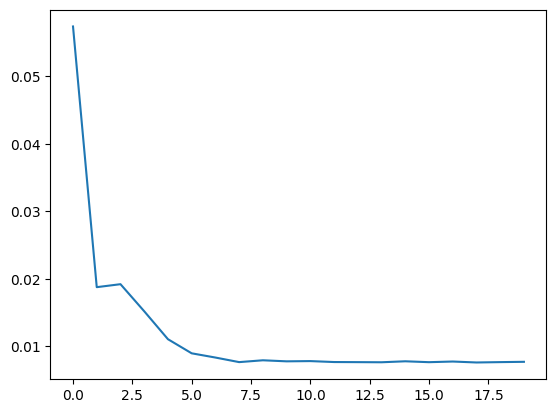

In [358]:
np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cpu')

seq_len = 60
batch_size = 64
n_epochs = 20
n_features = 82

model = CNN(seq_len, n_features)
criterion = nn.L1Loss()
optimizer = optimizers.Adam(
    model.parameters(),
    lr = 0.005,
)

def compute_loss(y, yhat):
    return criterion(yhat, y)

def train_step(x, y):
    model.train()
    yhat = model(x)
    loss = compute_loss(y, yhat.reshape(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


history = {'train_loss': []}
epochs = 20
for epoch in range(epochs):
    train_loss = 0.
    for x, y in train_dataloader:
        x = torch.Tensor(x).type(torch.float32).to(device)
        y = torch.Tensor(y).type(torch.float32).to(device)
        loss = train_step(x, y)
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    print('epoch: {}, train loss: {:.3}'.format(epoch, train_loss))
    history['train_loss'].append(train_loss)

y = history['train_loss']
x = np.arange(epochs)[:len(y)]
plt.plot(x, y)

In [456]:
def predict(x: torch.Tensor):
    model.eval()
    return model(x)

ys = []
ypreds = []
for X, y in test_dataloader:
    X = X.type(torch.float32).to(device)
    ypred = predict(X)
    ys.append(y)
    ypreds.append(ypred)
    
ys = torch.cat(ys)
ypreds = torch.cat(ypreds)

print('cnn2d precision score: {}'.format(precision_score(ys > 0, ypreds > 0)))
print('randonm precision score: {}'.format(precision_score(ys > 0, torch.randn(ys.shape) > 0)))

cnn2d precision score: 0.5605095541401274
randonm precision score: 0.5443037974683544
